<a href="https://colab.research.google.com/github/PHAN10M5/simple_image_classifier/blob/main/Human_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai icrawler --use-deprecated=legacy-resolver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00


In [2]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [3]:
from icrawler import ImageDownloader
from icrawler.builtin import GoogleImageCrawler
from icrawler.builtin.google import GoogleFeeder, GoogleParser

class MyDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(MyDownloader, self).get_filename(task, default_ext)
        filename = filename.split(".")[0]
        return self.prefix + filename + ".png"

class MyCrawler(GoogleImageCrawler):
    def __init__(self, feeder_cls=GoogleFeeder, parser_cls=GoogleParser, downloader_cls=MyDownloader, prefix="", *args, **kwargs):
        super().__init__(feeder_cls, parser_cls, downloader_cls, *args, **kwargs)
        self.downloader.prefix = prefix

In [4]:
def search_images(term, max_images=30, folder_name="."):
    print(f"Searching for '{term}'")
    crawler = MyCrawler(
        prefix=term,
        storage={'root_dir': folder_name},
    )
    crawler.crawl(keyword=term, max_num=max_images)

In [5]:
from fastai.vision.all import *

In [6]:
no_of_photos = 20

searches = 'cats', 'dogs'

path = Path('dataset')
from time import sleep

for o in searches:
    dest = (path/o)
    print(f'This is dest, {dest}')
    dest.mkdir(exist_ok=True, parents=True)
    search_images(f"{o} photo", no_of_photos, dest)
    sleep(10)
    print(f"Photos of {o} completed!")

resize_images(path, max_size=400, dest=path, recurse=True)
print(f"Photos resized!")

This is dest, dataset/cats
Searching for 'cats photo'


ERROR:downloader:Response status code 500, file https://plus.unsplash.com/premium_photo-1673967831980-1d377baaded2?fm=jpg


Photos of cats completed!
This is dest, dataset/dogs
Searching for 'dogs photo'


ERROR:downloader:Response status code 500, file https://plus.unsplash.com/premium_photo-1694819488591-a43907d1c5cc?fm=jpg
ERROR:downloader:Response status code 403, file https://www.uk.pedigree.com/cdn-cgi/image/format=auto,q=90/sites/g/files/fnmzdf5531/files/2023-06/pexels-sarah-chai-7282710.jpg
ERROR:downloader:Response status code 500, file https://plus.unsplash.com/premium_photo-1667727016915-baae2be5564e?fm=jpg
ERROR:downloader:Response status code 403, file https://paradepets.com/.image/w_3840,q_auto:good,c_fill,ar_4:3/MTkxMzY1Nzg4NjczMzIwNTQ2/cutest-dog-breeds-jpg


Photos of dogs completed!
Photos resized!


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

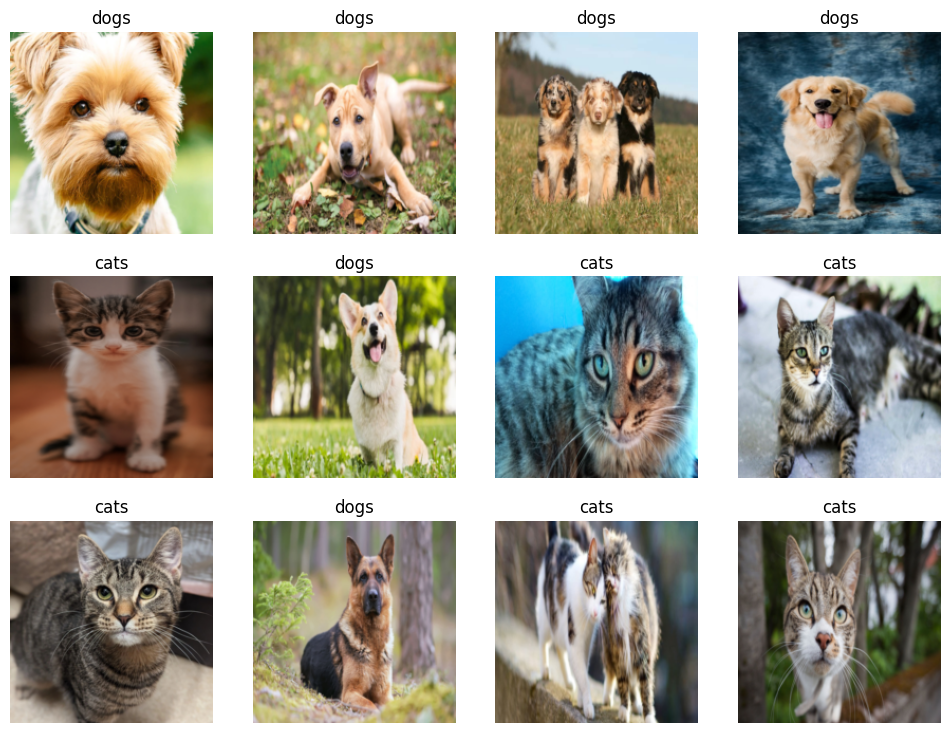

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.075902,1.888074,0.250000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.511154,1.238502,0.250000,00:00
1,1.282927,0.615504,0.250000,00:00
2,0.963924,0.178991,0.250000,00:00
3,0.765792,0.040397,0.000000,00:00
4,0.610939,0.011620,0.000000,00:00
5,0.506685,0.007632,0.000000,00:00
6,0.430022,0.010434,0.000000,00:00
7,0.372426,0.017139,0.000000,00:00
8,0.327701,0.029253,0.000000,00:00
9,0.291914,0.038350,0.000000,00:00


In [10]:
classes = list(learn.dls.vocab)

print(classes)

['cats', 'dogs']


In [12]:
import streamlit as st

st.title("Cat vs. Dog Classifier")
st.write("Upload an image to classify it as a cat or a dog.")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
  image = Image.open(uploaded_file)
  st.image(image, caption="Uploaded Image", use_column_width=True)
  predicted_class,_,probs = learn.predict(image)
  predicted_idx = classes.index(predicted_class)
  probabilities = {ele: probs[idx] for idx, ele in enumerate(classes)}
  st.write(f"Prediction: **{predicted_class}**")
  for ele in classes:
    st.write(f"Probability of {ele}: {probabilities[ele]:.4f}")

2025-02-09 23:08:29.020 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 23:08:29.104 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-09 23:08:29.105 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 23:08:29.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 23:08:29.110 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 23:08:29.111 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 23:08:29.113 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 23:08:29.115 Thread 'MainThread': mi

In [15]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
added 22 packages in 2s
⠋
⠋3 packages are looking for funding
⠋  run `npm fund` for details
⠋

In [17]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.185.192.35:8501

  Stopping...
^C


In [14]:
search_images('german_shepherd', 1)

Searching for 'german_shepherd'


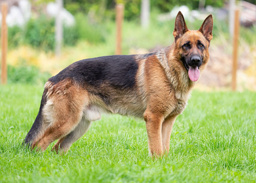

In [16]:
img = Image.open("german_shepherd000001.png")
img.to_thumb(256,256)

In [17]:
predicted_class,_,probs = learn.predict(img)
print(f"This is an image of: {predicted_class}.")
predicted_idx = classes.index(predicted_class)
for idx, ele in enumerate(classes):
    print(f"Probability it's from {ele} category: {probs[idx]:.4f}")

This is an image of: dogs.
Probability it's from cats category: 0.0103
Probability it's from dogs category: 0.9897
